# 1. Intro

- 셀레니움, BeautifulSoup 기반 인스타그램 크롤링
- '부산여행'과 관련한 인스타그램 인기 게시물들을 크롤링하여 분석 및 시각화 진행 
- 인스타그램 pc버전에서는 인기 게시물들을 상위 28개만 노출하고 있기 때문에 한 해시태그에 대해서 최대 28번의 크롤링만 가능
- 따라서 부산여행과 유사한 해시태그들로 바꾸어가면 총 **8개 해시태그에 대해서 28개 게시물을 크롤링하여 총 224개 게시물 데이터**를 수집하였음
- 수집 대상 해시태그들은 아래와 같다.
- #부산여행 #부산여행코스 #부산여행추천 #부산여행지 #부산여행중 #부산여행코스추천 #부산여행필수코스 #부산여행지추천

# 2. Crawling

In [66]:
# 1. 라이브러리 임포트
from bs4 import BeautifulSoup
import pandas as pd
import time
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import re
from bs4 import BeautifulSoup
import unicodedata
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc
import sys
import requests
from tqdm.notebook import tqdm
import folium
from wordcloud import WordCloud   
import platform

if sys.platform in ["win32", "win64"]:
    font_name = "malgun gothic"
elif sys.platform == "darwin":
    font_name = "AppleGothic"
rc('font',family=font_name)

if platform.system() == 'Windows':   
    font_path = "c:/Windows/Fonts/malgun.ttf"
elif platform.system() == "Darwin": 
    font_path = "/Users/$USER/Library/Fonts/AppleGothic.ttf"

In [ ]:
!pip install folium
!pip install WordCloud
!pip install tqdm 
!pip install folium

In [29]:
# 2. webdriver로 인스타그램 로그인 진행
chrome_driver_path = r"C:\Users\2011k\Downloads\chromedriver.exe"
service = Service(chrome_driver_path)
driver = webdriver.Chrome(service=service)

# 인스타그램 접속하기
url = 'https://www.instagram.com/'
driver.get(url)

# 아이디 입력
email = 'mincoder00'
input_id = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.NAME, 'username')))
input_id.clear()
input_id.send_keys(email)

# 비밀번호 입력
password = 'qhrmq001!'
input_pw = driver.find_element(By.NAME, 'password')
input_pw.clear()
input_pw.send_keys(password)

# 로그인 버튼 클릭
login_button = driver.find_element(By.XPATH, "//button[@type='submit']")
login_button.click()

In [8]:
# 3. tag에 해당하는 word를 추가하여 url 생성하는 함수
def insta_searching(word):
    url = 'https://www.instagram.com/explore/tags/'+word
    return url

In [9]:
# 4. 첫번째 게시물을 클릭하는 함수
def select_first(driver):
    first = driver.find_element('css selector', "div._aagw")  # selenium 명령어 변경으로 인한 코드 수정 (updated 2022.10.01) 
    first.click()
    time.sleep(3)

In [10]:
# 5. content를 크롤링하는 함수 : [content, date, like, place, tags] 저장
def get_content(driver):
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    try:
        content = soup.select('div._a9zs')[0].text  
        content = unicodedata.normalize('NFC', content) 
    except:
        content = ' '
    tags = re.findall(r'#[^\s#,\\]+', content)
    date = soup.select('time._a9ze._a9zf')[0]['datetime'][:10]
    try:
        like = soup.select('span.x193iq5w.xeuugli.x1fj9vlw.x13faqbe.x1vvkbs.xt0psk2.x1i0vuye.xvs91rp.x1s688f.x5n08af.x10wh9bi.x1wdrske.x8viiok.x18hxmgj')[0].text
    except IndexError:
        like = 0
    try: 
        place = soup.select('div._aaqm')[0].text
        place = unicodedata.normalize('NFC', place)
    except:
        place = ''
    data = [content, date, like, place, tags]
    return data

In [12]:
# 6. 다음 게시물로 넘기기
def move_next(driver):
    try:
        right_buttons = driver.find_elements('css selector', 'div._aaqg._aaqh > button._abl-')
        if right_buttons:
            right_buttons[0].click()
            time.sleep(3)
        else:
            print("No right buttons found")
    except Exception as e:
        print(f"An error occurred: {e}")
        time.sleep(2)
        move_next(driver)


In [30]:
# 7-1. '부산여행' 크롤링
word = '부산여행'
url = insta_searching(word)
driver.get(url)
time.sleep(7)
select_first(driver)
results = [ ]
target = 28      
for i in range(target):
    try:
        data = get_content(driver)  
        results.append(data)
        move_next(driver)
    except:
        time.sleep(2)
        move_next(driver)
print(results[:2])

No right buttons found
[['⠀이제 곳곳에 벚꽃이 피기 시작하니 꺼내보는 부산 사상구 벚꽃 맛집🌸 ⠀1-6 #우디브룩 @woodybrook_cafe 구덕터널 바로 위에 위치한 우디브룩은 벚꽃 나무가 크고 풍성해서 어디서 찍어도 너무 예쁜 곳이더라구요! 2층 테라스에서 디저트 놓고 찍으면 너무 예쁜데 딱 가운데 테이블은 포토존으로 운영해서 다른 자리 다 차있어도 사진 못 찍을 걱정 안 해도 돼서 좋았구 야외에도 자리가 많아서 봄날씨에 아주 딱인 곳이었어요. 그리고 바로 옆에 계곡물도 흘러서 바다와 다른 뻥 뚫리는 기분도 느낄 수 있구 귀여운 고양이도 아주아주 많아요🐱 ⠀7-10 #카페이띠 @cafe_itti 여긴 이미 너무 유명한 동서대 바로 앞 카페인데 벚꽃 시즌엔 루프탑이 다 포토존이라 줄서서 세군데 스팟마다 사진 찍을 수 있어서 좋은 곳이었어요! 딱 1층에서 음료 테이크아웃으로 주문하고 줄기다려서 찍으면 중간에 목 마를 일도 없구 또 작년엔 못가봤지만 바로 근처 #개금벚꽃길 도 너무 유명하니 묶어서 다녀오기도 좋답니다 !  ⠀*이 사진들은 작년 사진으로 올해 벚꽃 개화 상황은 태그된 계정에서 바로바로 확인하실 수 있어요!', '2024-03-25', '좋아요 745개', '부산광역시 사상구', ['#우디브룩', '#카페이띠', '#개금벚꽃길']], ['(리그램) @yachtholic부산여행은 가족과, 연인과, 친구와 와도 100% ! 아니, 1000% 만족하는 여행 코스 💖흰 천과 바람만 있다면 어디든 갈 수 있어 😎🛥2만원대로 즐길 수 있는 프리미엄 요트투어는 어디와 함께?요트홀릭과 함께!#부산여행 #부산여행필수코스 #부산여행코스 #부산가족여행 #부산가볼만한곳 #부산데이트', '2024-03-26', 'jess_camills', '', ['#부산여행', '#부산여행필수코스', '#부산여행코스', '#부산가족여행', '#부산가볼만한곳', '#부산데이트']]]


In [31]:
# 7-2. '부산여행코스' 크롤링
word = '부산여행코스'
url = insta_searching(word)
driver.get(url)
time.sleep(7)
select_first(driver)
target = 28     
for i in range(target):
    try:
        data = get_content(driver)  
        results.append(data)
        move_next(driver)
    except:
        time.sleep(2)
        move_next(driver)
print(results[:-2])

No right buttons found
[['⠀이제 곳곳에 벚꽃이 피기 시작하니 꺼내보는 부산 사상구 벚꽃 맛집🌸 ⠀1-6 #우디브룩 @woodybrook_cafe 구덕터널 바로 위에 위치한 우디브룩은 벚꽃 나무가 크고 풍성해서 어디서 찍어도 너무 예쁜 곳이더라구요! 2층 테라스에서 디저트 놓고 찍으면 너무 예쁜데 딱 가운데 테이블은 포토존으로 운영해서 다른 자리 다 차있어도 사진 못 찍을 걱정 안 해도 돼서 좋았구 야외에도 자리가 많아서 봄날씨에 아주 딱인 곳이었어요. 그리고 바로 옆에 계곡물도 흘러서 바다와 다른 뻥 뚫리는 기분도 느낄 수 있구 귀여운 고양이도 아주아주 많아요🐱 ⠀7-10 #카페이띠 @cafe_itti 여긴 이미 너무 유명한 동서대 바로 앞 카페인데 벚꽃 시즌엔 루프탑이 다 포토존이라 줄서서 세군데 스팟마다 사진 찍을 수 있어서 좋은 곳이었어요! 딱 1층에서 음료 테이크아웃으로 주문하고 줄기다려서 찍으면 중간에 목 마를 일도 없구 또 작년엔 못가봤지만 바로 근처 #개금벚꽃길 도 너무 유명하니 묶어서 다녀오기도 좋답니다 !  ⠀*이 사진들은 작년 사진으로 올해 벚꽃 개화 상황은 태그된 계정에서 바로바로 확인하실 수 있어요!', '2024-03-25', '좋아요 745개', '부산광역시 사상구', ['#우디브룩', '#카페이띠', '#개금벚꽃길']], ['(리그램) @yachtholic부산여행은 가족과, 연인과, 친구와 와도 100% ! 아니, 1000% 만족하는 여행 코스 💖흰 천과 바람만 있다면 어디든 갈 수 있어 😎🛥2만원대로 즐길 수 있는 프리미엄 요트투어는 어디와 함께?요트홀릭과 함께!#부산여행 #부산여행필수코스 #부산여행코스 #부산가족여행 #부산가볼만한곳 #부산데이트', '2024-03-26', 'jess_camills', '', ['#부산여행', '#부산여행필수코스', '#부산여행코스', '#부산가족여행', '#부산가볼만한곳', '#부산데이트']], ['영도 노을은 사랑이햐,,☕️✨좋아하는곳에 좋아하는시간 아껴두고싶은 순간들 🫧흰

In [32]:
# 7-3. '부산여행지' 크롤링
word = '부산여행지'
url = insta_searching(word)
driver.get(url)
time.sleep(7)
select_first(driver)
target = 28     
for i in range(target):
    try:
        data = get_content(driver)   
        results.append(data)
        move_next(driver)
    except:
        time.sleep(2)
        move_next(driver)
print(results[:-2])

No right buttons found
[['⠀이제 곳곳에 벚꽃이 피기 시작하니 꺼내보는 부산 사상구 벚꽃 맛집🌸 ⠀1-6 #우디브룩 @woodybrook_cafe 구덕터널 바로 위에 위치한 우디브룩은 벚꽃 나무가 크고 풍성해서 어디서 찍어도 너무 예쁜 곳이더라구요! 2층 테라스에서 디저트 놓고 찍으면 너무 예쁜데 딱 가운데 테이블은 포토존으로 운영해서 다른 자리 다 차있어도 사진 못 찍을 걱정 안 해도 돼서 좋았구 야외에도 자리가 많아서 봄날씨에 아주 딱인 곳이었어요. 그리고 바로 옆에 계곡물도 흘러서 바다와 다른 뻥 뚫리는 기분도 느낄 수 있구 귀여운 고양이도 아주아주 많아요🐱 ⠀7-10 #카페이띠 @cafe_itti 여긴 이미 너무 유명한 동서대 바로 앞 카페인데 벚꽃 시즌엔 루프탑이 다 포토존이라 줄서서 세군데 스팟마다 사진 찍을 수 있어서 좋은 곳이었어요! 딱 1층에서 음료 테이크아웃으로 주문하고 줄기다려서 찍으면 중간에 목 마를 일도 없구 또 작년엔 못가봤지만 바로 근처 #개금벚꽃길 도 너무 유명하니 묶어서 다녀오기도 좋답니다 !  ⠀*이 사진들은 작년 사진으로 올해 벚꽃 개화 상황은 태그된 계정에서 바로바로 확인하실 수 있어요!', '2024-03-25', '좋아요 745개', '부산광역시 사상구', ['#우디브룩', '#카페이띠', '#개금벚꽃길']], ['(리그램) @yachtholic부산여행은 가족과, 연인과, 친구와 와도 100% ! 아니, 1000% 만족하는 여행 코스 💖흰 천과 바람만 있다면 어디든 갈 수 있어 😎🛥2만원대로 즐길 수 있는 프리미엄 요트투어는 어디와 함께?요트홀릭과 함께!#부산여행 #부산여행필수코스 #부산여행코스 #부산가족여행 #부산가볼만한곳 #부산데이트', '2024-03-26', 'jess_camills', '', ['#부산여행', '#부산여행필수코스', '#부산여행코스', '#부산가족여행', '#부산가볼만한곳', '#부산데이트']], ['영도 노을은 사랑이햐,,☕️✨좋아하는곳에 좋아하는시간 아껴두고싶은 순간들 🫧흰

In [33]:
# 7-4. '부산여행추천' 크롤링
word = '부산여행추천'
url = insta_searching(word)
driver.get(url)
time.sleep(7)
select_first(driver)
target = 28      
for i in range(target):
    try:
        data = get_content(driver)    
        results.append(data)
        move_next(driver)
    except:
        time.sleep(2)
        move_next(driver)
print(results[:-2])

No right buttons found
[['⠀이제 곳곳에 벚꽃이 피기 시작하니 꺼내보는 부산 사상구 벚꽃 맛집🌸 ⠀1-6 #우디브룩 @woodybrook_cafe 구덕터널 바로 위에 위치한 우디브룩은 벚꽃 나무가 크고 풍성해서 어디서 찍어도 너무 예쁜 곳이더라구요! 2층 테라스에서 디저트 놓고 찍으면 너무 예쁜데 딱 가운데 테이블은 포토존으로 운영해서 다른 자리 다 차있어도 사진 못 찍을 걱정 안 해도 돼서 좋았구 야외에도 자리가 많아서 봄날씨에 아주 딱인 곳이었어요. 그리고 바로 옆에 계곡물도 흘러서 바다와 다른 뻥 뚫리는 기분도 느낄 수 있구 귀여운 고양이도 아주아주 많아요🐱 ⠀7-10 #카페이띠 @cafe_itti 여긴 이미 너무 유명한 동서대 바로 앞 카페인데 벚꽃 시즌엔 루프탑이 다 포토존이라 줄서서 세군데 스팟마다 사진 찍을 수 있어서 좋은 곳이었어요! 딱 1층에서 음료 테이크아웃으로 주문하고 줄기다려서 찍으면 중간에 목 마를 일도 없구 또 작년엔 못가봤지만 바로 근처 #개금벚꽃길 도 너무 유명하니 묶어서 다녀오기도 좋답니다 !  ⠀*이 사진들은 작년 사진으로 올해 벚꽃 개화 상황은 태그된 계정에서 바로바로 확인하실 수 있어요!', '2024-03-25', '좋아요 745개', '부산광역시 사상구', ['#우디브룩', '#카페이띠', '#개금벚꽃길']], ['(리그램) @yachtholic부산여행은 가족과, 연인과, 친구와 와도 100% ! 아니, 1000% 만족하는 여행 코스 💖흰 천과 바람만 있다면 어디든 갈 수 있어 😎🛥2만원대로 즐길 수 있는 프리미엄 요트투어는 어디와 함께?요트홀릭과 함께!#부산여행 #부산여행필수코스 #부산여행코스 #부산가족여행 #부산가볼만한곳 #부산데이트', '2024-03-26', 'jess_camills', '', ['#부산여행', '#부산여행필수코스', '#부산여행코스', '#부산가족여행', '#부산가볼만한곳', '#부산데이트']], ['영도 노을은 사랑이햐,,☕️✨좋아하는곳에 좋아하는시간 아껴두고싶은 순간들 🫧흰

In [35]:
# 7-5. '부산여행중' 크롤링
word = '부산여행중'
url = insta_searching(word)
driver.get(url)
time.sleep(7)
select_first(driver)
target = 28    
for i in range(target):
    try:
        data = get_content(driver) 
        results.append(data)
        move_next(driver)
    except:
        time.sleep(2)
        move_next(driver)    
print(results[:-2])

No right buttons found
[['⠀이제 곳곳에 벚꽃이 피기 시작하니 꺼내보는 부산 사상구 벚꽃 맛집🌸 ⠀1-6 #우디브룩 @woodybrook_cafe 구덕터널 바로 위에 위치한 우디브룩은 벚꽃 나무가 크고 풍성해서 어디서 찍어도 너무 예쁜 곳이더라구요! 2층 테라스에서 디저트 놓고 찍으면 너무 예쁜데 딱 가운데 테이블은 포토존으로 운영해서 다른 자리 다 차있어도 사진 못 찍을 걱정 안 해도 돼서 좋았구 야외에도 자리가 많아서 봄날씨에 아주 딱인 곳이었어요. 그리고 바로 옆에 계곡물도 흘러서 바다와 다른 뻥 뚫리는 기분도 느낄 수 있구 귀여운 고양이도 아주아주 많아요🐱 ⠀7-10 #카페이띠 @cafe_itti 여긴 이미 너무 유명한 동서대 바로 앞 카페인데 벚꽃 시즌엔 루프탑이 다 포토존이라 줄서서 세군데 스팟마다 사진 찍을 수 있어서 좋은 곳이었어요! 딱 1층에서 음료 테이크아웃으로 주문하고 줄기다려서 찍으면 중간에 목 마를 일도 없구 또 작년엔 못가봤지만 바로 근처 #개금벚꽃길 도 너무 유명하니 묶어서 다녀오기도 좋답니다 !  ⠀*이 사진들은 작년 사진으로 올해 벚꽃 개화 상황은 태그된 계정에서 바로바로 확인하실 수 있어요!', '2024-03-25', '좋아요 745개', '부산광역시 사상구', ['#우디브룩', '#카페이띠', '#개금벚꽃길']], ['(리그램) @yachtholic부산여행은 가족과, 연인과, 친구와 와도 100% ! 아니, 1000% 만족하는 여행 코스 💖흰 천과 바람만 있다면 어디든 갈 수 있어 😎🛥2만원대로 즐길 수 있는 프리미엄 요트투어는 어디와 함께?요트홀릭과 함께!#부산여행 #부산여행필수코스 #부산여행코스 #부산가족여행 #부산가볼만한곳 #부산데이트', '2024-03-26', 'jess_camills', '', ['#부산여행', '#부산여행필수코스', '#부산여행코스', '#부산가족여행', '#부산가볼만한곳', '#부산데이트']], ['영도 노을은 사랑이햐,,☕️✨좋아하는곳에 좋아하는시간 아껴두고싶은 순간들 🫧흰

In [36]:
# 7-6. '부산여행코스추천' 크롤링
word = '부산여행코스추천'
url = insta_searching(word)
driver.get(url)
time.sleep(7)
select_first(driver)
target = 28      
for i in range(target):
    try:
        data = get_content(driver)  
        results.append(data)
        move_next(driver)
    except:
        time.sleep(2)
        move_next(driver)    
print(results[:-2])

No right buttons found
[['⠀이제 곳곳에 벚꽃이 피기 시작하니 꺼내보는 부산 사상구 벚꽃 맛집🌸 ⠀1-6 #우디브룩 @woodybrook_cafe 구덕터널 바로 위에 위치한 우디브룩은 벚꽃 나무가 크고 풍성해서 어디서 찍어도 너무 예쁜 곳이더라구요! 2층 테라스에서 디저트 놓고 찍으면 너무 예쁜데 딱 가운데 테이블은 포토존으로 운영해서 다른 자리 다 차있어도 사진 못 찍을 걱정 안 해도 돼서 좋았구 야외에도 자리가 많아서 봄날씨에 아주 딱인 곳이었어요. 그리고 바로 옆에 계곡물도 흘러서 바다와 다른 뻥 뚫리는 기분도 느낄 수 있구 귀여운 고양이도 아주아주 많아요🐱 ⠀7-10 #카페이띠 @cafe_itti 여긴 이미 너무 유명한 동서대 바로 앞 카페인데 벚꽃 시즌엔 루프탑이 다 포토존이라 줄서서 세군데 스팟마다 사진 찍을 수 있어서 좋은 곳이었어요! 딱 1층에서 음료 테이크아웃으로 주문하고 줄기다려서 찍으면 중간에 목 마를 일도 없구 또 작년엔 못가봤지만 바로 근처 #개금벚꽃길 도 너무 유명하니 묶어서 다녀오기도 좋답니다 !  ⠀*이 사진들은 작년 사진으로 올해 벚꽃 개화 상황은 태그된 계정에서 바로바로 확인하실 수 있어요!', '2024-03-25', '좋아요 745개', '부산광역시 사상구', ['#우디브룩', '#카페이띠', '#개금벚꽃길']], ['(리그램) @yachtholic부산여행은 가족과, 연인과, 친구와 와도 100% ! 아니, 1000% 만족하는 여행 코스 💖흰 천과 바람만 있다면 어디든 갈 수 있어 😎🛥2만원대로 즐길 수 있는 프리미엄 요트투어는 어디와 함께?요트홀릭과 함께!#부산여행 #부산여행필수코스 #부산여행코스 #부산가족여행 #부산가볼만한곳 #부산데이트', '2024-03-26', 'jess_camills', '', ['#부산여행', '#부산여행필수코스', '#부산여행코스', '#부산가족여행', '#부산가볼만한곳', '#부산데이트']], ['영도 노을은 사랑이햐,,☕️✨좋아하는곳에 좋아하는시간 아껴두고싶은 순간들 🫧흰

In [37]:
# 7-7. '부산여행지추천' 크롤링
word = '부산여행지추천'
url = insta_searching(word)
driver.get(url)
time.sleep(7)
select_first(driver)
target = 28      
for i in range(target):
    try:
        data = get_content(driver)   
        results.append(data)
        move_next(driver)
    except:
        time.sleep(2)
        move_next(driver)
print(results[:-2])

No right buttons found
[['⠀이제 곳곳에 벚꽃이 피기 시작하니 꺼내보는 부산 사상구 벚꽃 맛집🌸 ⠀1-6 #우디브룩 @woodybrook_cafe 구덕터널 바로 위에 위치한 우디브룩은 벚꽃 나무가 크고 풍성해서 어디서 찍어도 너무 예쁜 곳이더라구요! 2층 테라스에서 디저트 놓고 찍으면 너무 예쁜데 딱 가운데 테이블은 포토존으로 운영해서 다른 자리 다 차있어도 사진 못 찍을 걱정 안 해도 돼서 좋았구 야외에도 자리가 많아서 봄날씨에 아주 딱인 곳이었어요. 그리고 바로 옆에 계곡물도 흘러서 바다와 다른 뻥 뚫리는 기분도 느낄 수 있구 귀여운 고양이도 아주아주 많아요🐱 ⠀7-10 #카페이띠 @cafe_itti 여긴 이미 너무 유명한 동서대 바로 앞 카페인데 벚꽃 시즌엔 루프탑이 다 포토존이라 줄서서 세군데 스팟마다 사진 찍을 수 있어서 좋은 곳이었어요! 딱 1층에서 음료 테이크아웃으로 주문하고 줄기다려서 찍으면 중간에 목 마를 일도 없구 또 작년엔 못가봤지만 바로 근처 #개금벚꽃길 도 너무 유명하니 묶어서 다녀오기도 좋답니다 !  ⠀*이 사진들은 작년 사진으로 올해 벚꽃 개화 상황은 태그된 계정에서 바로바로 확인하실 수 있어요!', '2024-03-25', '좋아요 745개', '부산광역시 사상구', ['#우디브룩', '#카페이띠', '#개금벚꽃길']], ['(리그램) @yachtholic부산여행은 가족과, 연인과, 친구와 와도 100% ! 아니, 1000% 만족하는 여행 코스 💖흰 천과 바람만 있다면 어디든 갈 수 있어 😎🛥2만원대로 즐길 수 있는 프리미엄 요트투어는 어디와 함께?요트홀릭과 함께!#부산여행 #부산여행필수코스 #부산여행코스 #부산가족여행 #부산가볼만한곳 #부산데이트', '2024-03-26', 'jess_camills', '', ['#부산여행', '#부산여행필수코스', '#부산여행코스', '#부산가족여행', '#부산가볼만한곳', '#부산데이트']], ['영도 노을은 사랑이햐,,☕️✨좋아하는곳에 좋아하는시간 아껴두고싶은 순간들 🫧흰

In [38]:
# 7-8. '부산여행필수코스' 크롤링
word = '부산여행필수코스'
url = insta_searching(word)
driver.get(url)
time.sleep(7)
select_first(driver)
target = 28     
for i in range(target):
    try:
        data = get_content(driver)  
        results.append(data)
        move_next(driver)
    except:
        time.sleep(2)
        move_next(driver)
print(results[:-2])

No right buttons found
[['⠀이제 곳곳에 벚꽃이 피기 시작하니 꺼내보는 부산 사상구 벚꽃 맛집🌸 ⠀1-6 #우디브룩 @woodybrook_cafe 구덕터널 바로 위에 위치한 우디브룩은 벚꽃 나무가 크고 풍성해서 어디서 찍어도 너무 예쁜 곳이더라구요! 2층 테라스에서 디저트 놓고 찍으면 너무 예쁜데 딱 가운데 테이블은 포토존으로 운영해서 다른 자리 다 차있어도 사진 못 찍을 걱정 안 해도 돼서 좋았구 야외에도 자리가 많아서 봄날씨에 아주 딱인 곳이었어요. 그리고 바로 옆에 계곡물도 흘러서 바다와 다른 뻥 뚫리는 기분도 느낄 수 있구 귀여운 고양이도 아주아주 많아요🐱 ⠀7-10 #카페이띠 @cafe_itti 여긴 이미 너무 유명한 동서대 바로 앞 카페인데 벚꽃 시즌엔 루프탑이 다 포토존이라 줄서서 세군데 스팟마다 사진 찍을 수 있어서 좋은 곳이었어요! 딱 1층에서 음료 테이크아웃으로 주문하고 줄기다려서 찍으면 중간에 목 마를 일도 없구 또 작년엔 못가봤지만 바로 근처 #개금벚꽃길 도 너무 유명하니 묶어서 다녀오기도 좋답니다 !  ⠀*이 사진들은 작년 사진으로 올해 벚꽃 개화 상황은 태그된 계정에서 바로바로 확인하실 수 있어요!', '2024-03-25', '좋아요 745개', '부산광역시 사상구', ['#우디브룩', '#카페이띠', '#개금벚꽃길']], ['(리그램) @yachtholic부산여행은 가족과, 연인과, 친구와 와도 100% ! 아니, 1000% 만족하는 여행 코스 💖흰 천과 바람만 있다면 어디든 갈 수 있어 😎🛥2만원대로 즐길 수 있는 프리미엄 요트투어는 어디와 함께?요트홀릭과 함께!#부산여행 #부산여행필수코스 #부산여행코스 #부산가족여행 #부산가볼만한곳 #부산데이트', '2024-03-26', 'jess_camills', '', ['#부산여행', '#부산여행필수코스', '#부산여행코스', '#부산가족여행', '#부산가볼만한곳', '#부산데이트']], ['영도 노을은 사랑이햐,,☕️✨좋아하는곳에 좋아하는시간 아껴두고싶은 순간들 🫧흰

In [44]:
results_df = pd.DataFrame(results)
results_df.columns = ['content','data','like','place','tags']
results_df.to_excel("./results_df.xlsx", index=False)

In [45]:
results_df

,content,data,like,place,tags
0,⠀이제 곳곳에 벚꽃이 피기 시작하니 꺼내보는 부산 사상구 벚꽃 맛집🌸 ⠀1-6 #우...,2024-03-25,좋아요 745개,부산광역시 사상구,"[#우디브룩, #카페이띠, #개금벚꽃길]"
1,"(리그램) @yachtholic부산여행은 가족과, 연인과, 친구와 와도 100% !...",2024-03-26,jess_camills,,"[#부산여행, #부산여행필수코스, #부산여행코스, #부산가족여행, #부산가볼만한곳,..."
2,"영도 노을은 사랑이햐,,☕️✨좋아하는곳에 좋아하는시간 아껴두고싶은 순간들 🫧흰여울길...",2024-03-09,좋아요 1597개,부산,"[#몰리스📍부산, #ug_부산]"
3,벚꽃 시즌에 당장 가야하는 부산🌸부산에서 꼭 가야하는 개금벚꽃길!이번에도 정말 기대...,2024-03-10,좋아요 5875개,부산,[]
4,남쪽 바다에 설렘이 찾아오는 순간💛📍부산 오륙도,2024-03-06,좋아요 2114개,오륙도,[]
...,...,...,...,...,...
218,"금일 짚라인 3시, 4시, 5시 타임 남아있습니다〰️☑️문의 전화: 051-404-...",2024-03-23,좋아요 27개,부산 태종대,"[#짚라인, #부산주말나들이, #부산주말데이트]"
219,바다와 도시를 넘나드는🛝 200m 튜브 슬라이드 등장🔥 부산 #클럽디오아시스7/5 ...,2023-07-26,좋아요 4106개,,[#클럽디오아시스7/5]
220,부산 오션뷰 원탑 찍은 신상 카페 뜸;;영도 태종대 >>스릴온더머그<< 인데기장 오...,2024-03-26,kimsamsun8888,,"[#스릴온더머그, #부산카페, #부산오션뷰카페, #오션뷰카페, #부산갈만한곳, #부..."
221,부산에 갈 이유는 이거하나로 충.분.하.다🔥🔥🔥지글지글 양념양곱창구이+소주=극락행 ...,2023-08-08,좋아요 1333개,부산 남포동,"[#대정양곱창, #양념구이, #부산맛집, #부산맛집추천, #양곱창, #양대창, #부..."


# 3. Data Analytics

In [47]:
# 1. 태그 분석 : 상위 30개 태그 시각화
results_df['tags']

0                                 [#우디브룩, #카페이띠, #개금벚꽃길]
1      [#부산여행, #부산여행필수코스, #부산여행코스, #부산가족여행, #부산가볼만한곳,...
2                                      [#몰리스📍부산, #ug_부산]
3                                                     []
4                                                     []
                             ...                        
218                           [#짚라인, #부산주말나들이, #부산주말데이트]
219                                        [#클럽디오아시스7/5]
220    [#스릴온더머그, #부산카페, #부산오션뷰카페, #오션뷰카페, #부산갈만한곳, #부...
221    [#대정양곱창, #양념구이, #부산맛집, #부산맛집추천, #양곱창, #양대창, #부...
222    [#부산요트투어, #부산여행, #부산여행코스, #부산여행필수코스, #부산가볼만한곳,...
Name: tags, Length: 223, dtype: object

In [48]:
tags_total = []

for tags_list in results_df['tags']:
    for tag in tags_list:
        tag_without_hash = tag[1:]  # Removing the '#' character
        tags_total.append(tag_without_hash)

In [49]:
tags_total

['우디브룩',
 '카페이띠',
 '개금벚꽃길',
 '부산여행',
 '부산여행필수코스',
 '부산여행코스',
 '부산가족여행',
 '부산가볼만한곳',
 '부산데이트',
 '몰리스📍부산',
 'ug_부산',
 '부산여행',
 '청사포',
 '송정해변',
 '해변열차',
 '서핑',
 '서핑의성지',
 '열차여행',
 '인생사진',
 '여행스타그램“',
 '부산숙소',
 '대저생태공원',
 '유채꽃',
 '부산가볼만한곳',
 '부산여행',
 '사진소통',
 '사진계정',
 '사진스타그램',
 '사진계정맞팔',
 '사진작가',
 '작가',
 '일상스냅',
 '스냅',
 '스냅작가',
 '색감보정',
 '라이트룸',
 '보정',
 '카메라',
 '소니이미지갤러리',
 '소니',
 '소니카메라',
 'sonya7m4',
 'a7m4',
 'tamron28200',
 '49번포차-이제',
 '마쓰_남포📍부산',
 '부산포장마차',
 '남포동포장마차',
 '부산야장',
 '부산노포맛집',
 '포장마차맛집',
 '부산여행',
 '남포동여행',
 '남포술집',
 '노포맛집⠀노상의',
 '학리방파제⠀⠀📍',
 '캠핑에미치다',
 '캠미',
 '부산학리방파제',
 '부산포차',
 '부산포차거리',
 '부산핫플',
 '기장핫플',
 '기장포차',
 '기장맛집',
 '부산맛집',
 '기장학리방파제',
 '기장데이트',
 '부산데이트',
 '부산맛집추천',
 '부산노상',
 '부산야장',
 '부산여행⠀',
 '동래맛집',
 '청도미나리식당역대급',
 '해푸_동래',
 '주말',
 '광안리',
 '광안대교',
 '부산여행',
 '해운대',
 '오션브리즈',
 '무브먼트랩',
 '청사포',
 '미포',
 '스카이캡슐',
 '부산여행',
 '해운대블루라인파크',
 '해변열차',
 '부산가볼만한곳',
 '달맞이길카페',
 '해운대카페',
 '청사포카페',
 'Ryan吃韓國',
 'reels',
 'busan',
 'busantrip',
 'busantravel',
 '釜山',
 '釜山旅行',

In [57]:
tag_counts_df = pd.DataFrame(tag_counts.most_common(30))
tag_counts_df.columns = ['tags', 'counts']

<Axes: xlabel='counts', ylabel='tags'>

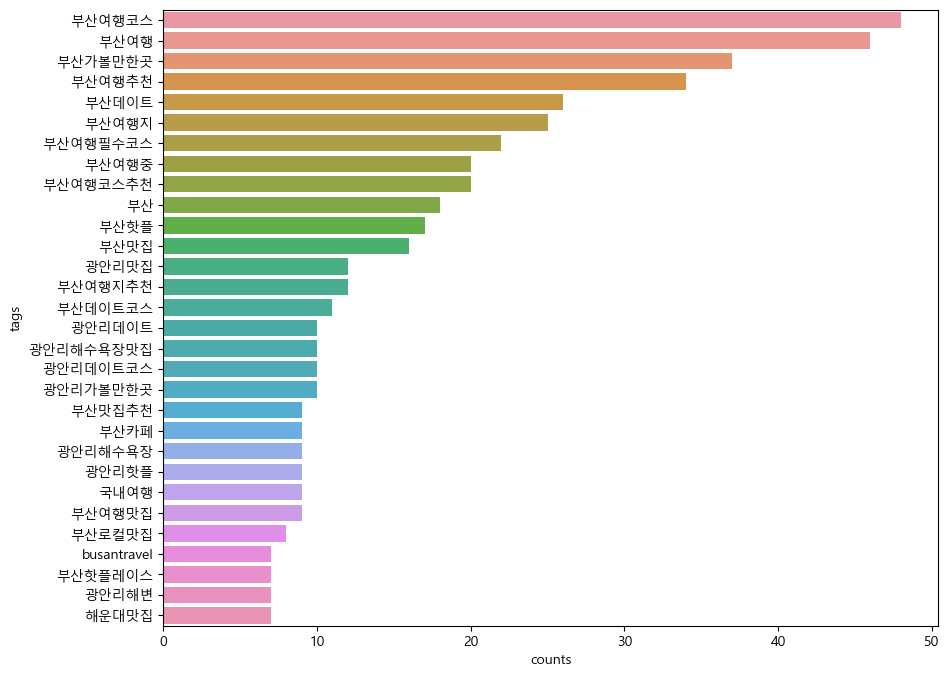

In [58]:
plt.figure(figsize=(10,8)) 
sns.barplot(x='counts', y='tags', data = tag_counts_df)

In [59]:
tag_counts_df

,tags,counts
0,부산여행코스,48
1,부산여행,46
2,부산가볼만한곳,37
3,부산여행추천,34
4,부산데이트,26
5,부산여행지,25
6,부산여행필수코스,22
7,부산여행중,20
8,부산여행코스추천,20
9,부산,18


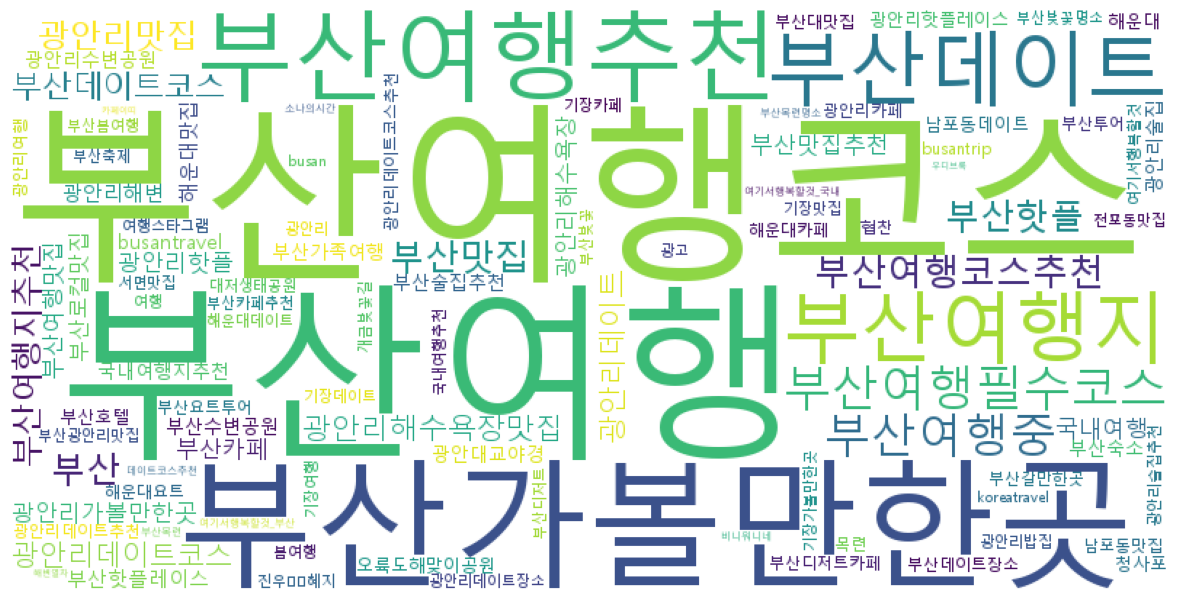

In [67]:
wordcloud=WordCloud(font_path= font_path, 
                    background_color="white",
                    max_words=100,
                    relative_scaling= 0.3,
                    width = 800,
                    height = 400
                 ).generate_from_frequencies(tag_counts)  
plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('./wordcloud.png') 

In [68]:
# 2. 장소 분석
location_counts = results_df['place'].value_counts()
location_counts

                                                138
부산                                               20
Busan 釜山, South Korea                            13
광안리해수욕장 GwangalliBeach, Busan, Korea 廣安里海水浴場      4
Busan 부산                                          4
영도                                                3
부산 개금동                                            3
부산광역시 사상구                                         2
청사포                                               2
광안리                                               1
부산 기장                                             1
광안리해수욕장                                           1
부산광역시                                             1
Busan Korea                                       1
오륙도 해맞이공원                                         1
부산 남천동                                            1
나이아가라폴스                                           1
다대포 해수욕장 / Dadaepo Beach                          1
기장 학리 방파제                                         1
흰여울문화마을     

In [69]:
location_counts_df = pd.DataFrame(location_counts)
location_counts_df.head()

,place
,138
부산,20
"Busan 釜山, South Korea",13
"광안리해수욕장 GwangalliBeach, Busan, Korea 廣安里海水浴場",4
Busan 부산,4


In [95]:
locations = list(location_counts.index )
locations 

['',
 '부산',
 'Busan 釜山, South Korea',
 '광안리해수욕장 GwangalliBeach, Busan, Korea 廣安里海水浴場',
 'Busan 부산',
 '영도',
 '부산 개금동',
 '부산광역시 사상구',
 '청사포',
 '광안리',
 '부산 기장',
 '광안리해수욕장',
 '부산광역시',
 'Busan Korea',
 '오륙도 해맞이공원',
 '부산 남천동',
 '나이아가라폴스',
 '다대포 해수욕장 / Dadaepo Beach',
 '기장 학리 방파제',
 '흰여울문화마을',
 '전포카페거리 전리단길 전포사잇길',
 'Happy New Years 2024',
 '해목',
 '부산 태종대',
 '부산대학교 Pusan National University - PNU',
 '민락골목시장',
 '닥밭골 벽화마을',
 'F1963',
 '오륙도',
 '대저생태공원',
 '부산 호시카게 료칸 호텔',
 '부산 영도',
 '남포동 깡통시장',
 '장림포구',
 '해운대해수욕장 - Haeundae Beach',
 '할매재첩국',
 'Bs부산은행 조은극장 1관',
 'Haeundae, Busan',
 '부산아쿠아리움',
 '전포동',
 '서동미로시장',
 '부산역',
 '부산 남포동']

In [71]:
searching = '합정 스타벅스'
url = 'https://dapi.kakao.com/v2/local/search/keyword.json?query={}'.format(searching)
headers = {
    "Authorization": "KakaoAK 63ead6acf8870f335ceee1b3ca07c5fc"
}
places = requests.get(url, headers = headers).json()['documents']
places

[{'address_name': '서울 마포구 합정동 472',
  'category_group_code': 'CE7',
  'category_group_name': '카페',
  'category_name': '음식점 > 카페 > 커피전문점 > 스타벅스',
  'distance': '',
  'id': '2057327896',
  'phone': '1522-3232',
  'place_name': '스타벅스 합정점',
  'place_url': 'http://place.map.kakao.com/2057327896',
  'road_address_name': '서울 마포구 월드컵로1길 14',
  'x': '126.91253700818196',
  'y': '37.54994959743763'},
 {'address_name': '서울 마포구 합정동 473',
  'category_group_code': 'CE7',
  'category_group_name': '카페',
  'category_name': '음식점 > 카페 > 커피전문점 > 스타벅스',
  'distance': '',
  'id': '2132676511',
  'phone': '1522-3232',
  'place_name': '스타벅스 합정푸르지오점',
  'place_url': 'http://place.map.kakao.com/2132676511',
  'road_address_name': '서울 마포구 월드컵로3길 14',
  'x': '126.91247704039314',
  'y': '37.550909116022105'},
 {'address_name': '서울 마포구 서교동 490',
  'category_group_code': 'CE7',
  'category_group_name': '카페',
  'category_name': '음식점 > 카페 > 커피전문점 > 스타벅스',
  'distance': '',
  'id': '27076117',
  'phone': '1522-3232',


In [72]:
def find_places(searching):
    url = 'https://dapi.kakao.com/v2/local/search/keyword.json?query={}'.format(searching)
    headers = {
    "Authorization": "KakaoAK 63ead6acf8870f335ceee1b3ca07c5fc"
    }
    places = requests.get(url, headers = headers).json()['documents']
    place = places[0] 
    name = place['place_name']
    x=place['x']
    y=place['y']
    data = [name, x, y, searching] 
    return data

In [96]:
locations_inform = [ ]
for location in tqdm(locations):
    try:
        data = find_places(location)       
        locations_inform.append(data) 
        time.sleep(0.5) 
    except:
        pass
locations_inform

  0%|          | 0/43 [00:00<?, ?it/s]

[['해운대해수욕장', '129.159854668484', '35.1585232170784', '부산'],
 ['Gostoso Busan 고스또소 부산', '129.06507704572', '35.1448279261882', 'Busan 부산'],
 ['흰여울문화마을', '129.04528136992104', '35.077914827298564', '영도'],
 ['개금벚꽃길', '129.01640577968', '35.1461508047688', '부산 개금동'],
 ['갈맷길 6코스2구간', '129.01029131667113', '35.18061047847551', '부산광역시 사상구'],
 ['청사포어항북방파제등대', '129.191520969114', '35.1592915773208', '청사포'],
 ['광안리해수욕장', '129.118976093583', '35.1531932736837', '광안리'],
 ['임랑해수욕장', '129.26405780900492', '35.31903428666247', '부산 기장'],
 ['광안리해수욕장', '129.118976093583', '35.1531932736837', '광안리해수욕장'],
 ['해운대블루라인파크 미포정거장', '129.17281473802996', '35.15815259880406', '부산광역시'],
 ['부산고려병원', '129.09259983874438', '35.13490060392044', 'Busan Korea'],
 ['오륙도해맞이소공원', '129.12262681981733', '35.10266653511379', '오륙도 해맞이공원'],
 ['남천동벚꽃거리', '129.115159005451', '35.1425615144113', '부산 남천동'],
 ['학리방파제', '129.24749611914143', '35.26021992456166', '기장 학리 방파제'],
 ['흰여울문화마을', '129.04528136992104', '35.077914827298564', '

In [97]:
locations_inform_df = pd.DataFrame(locations_inform)
locations_inform_df.columns = ['name_official','경도','위도','인스타위치명']
locations_inform_df.to_excel('./locations.xlsx', index=False)

In [98]:
locations_inform_df

,name_official,경도,위도,인스타위치명
0,해운대해수욕장,129.159854668484,35.1585232170784,부산
1,Gostoso Busan 고스또소 부산,129.06507704572,35.1448279261882,Busan 부산
2,흰여울문화마을,129.04528136992104,35.077914827298564,영도
3,개금벚꽃길,129.01640577968,35.1461508047688,부산 개금동
4,갈맷길 6코스2구간,129.01029131667113,35.18061047847551,부산광역시 사상구
5,청사포어항북방파제등대,129.191520969114,35.1592915773208,청사포
6,광안리해수욕장,129.118976093583,35.1531932736837,광안리
7,임랑해수욕장,129.26405780900492,35.31903428666247,부산 기장
8,광안리해수욕장,129.118976093583,35.1531932736837,광안리해수욕장
9,해운대블루라인파크 미포정거장,129.17281473802996,35.15815259880406,부산광역시


In [103]:
Gwangalli=[35.1542634, 129.1204897]

map_busan = folium.Map(location = Gwangalli, zoom_start = 11)

for i in range(len(locations_inform_df)):
    name = locations_inform_df ['name_official']    
    long = float(locations_inform_df['위도'][i])      
    lat = float(locations_inform_df['경도'][i])       
    folium.CircleMarker((long,lat), color='red', popup=name).add_to(map_busan)
    
map_busan

In [ ]:
# 3. 좋아요 분석 : 상위 5개 top liked 게시물 content 조회

In [89]:
results_df['like_count'] = results_df['like'].str.extract(r'좋아요 (\d+)개').astype(float)
results_df['like_count'] = results_df['like_count'].fillna(0)

In [90]:
results_df

,content,data,like,place,tags,like_count
0,⠀이제 곳곳에 벚꽃이 피기 시작하니 꺼내보는 부산 사상구 벚꽃 맛집🌸 ⠀1-6 #우...,2024-03-25,좋아요 745개,부산광역시 사상구,"[#우디브룩, #카페이띠, #개금벚꽃길]",745.0
1,"(리그램) @yachtholic부산여행은 가족과, 연인과, 친구와 와도 100% !...",2024-03-26,jess_camills,,"[#부산여행, #부산여행필수코스, #부산여행코스, #부산가족여행, #부산가볼만한곳,...",NaN
2,"영도 노을은 사랑이햐,,☕️✨좋아하는곳에 좋아하는시간 아껴두고싶은 순간들 🫧흰여울길...",2024-03-09,좋아요 1597개,부산,"[#몰리스📍부산, #ug_부산]",1597.0
3,벚꽃 시즌에 당장 가야하는 부산🌸부산에서 꼭 가야하는 개금벚꽃길!이번에도 정말 기대...,2024-03-10,좋아요 5875개,부산,[],5875.0
4,남쪽 바다에 설렘이 찾아오는 순간💛📍부산 오륙도,2024-03-06,좋아요 2114개,오륙도,[],2114.0
...,...,...,...,...,...,...
218,"금일 짚라인 3시, 4시, 5시 타임 남아있습니다〰️☑️문의 전화: 051-404-...",2024-03-23,좋아요 27개,부산 태종대,"[#짚라인, #부산주말나들이, #부산주말데이트]",27.0
219,바다와 도시를 넘나드는🛝 200m 튜브 슬라이드 등장🔥 부산 #클럽디오아시스7/5 ...,2023-07-26,좋아요 4106개,,[#클럽디오아시스7/5],4106.0
220,부산 오션뷰 원탑 찍은 신상 카페 뜸;;영도 태종대 >>스릴온더머그<< 인데기장 오...,2024-03-26,kimsamsun8888,,"[#스릴온더머그, #부산카페, #부산오션뷰카페, #오션뷰카페, #부산갈만한곳, #부...",NaN
221,부산에 갈 이유는 이거하나로 충.분.하.다🔥🔥🔥지글지글 양념양곱창구이+소주=극락행 ...,2023-08-08,좋아요 1333개,부산 남포동,"[#대정양곱창, #양념구이, #부산맛집, #부산맛집추천, #양곱창, #양대창, #부...",1333.0


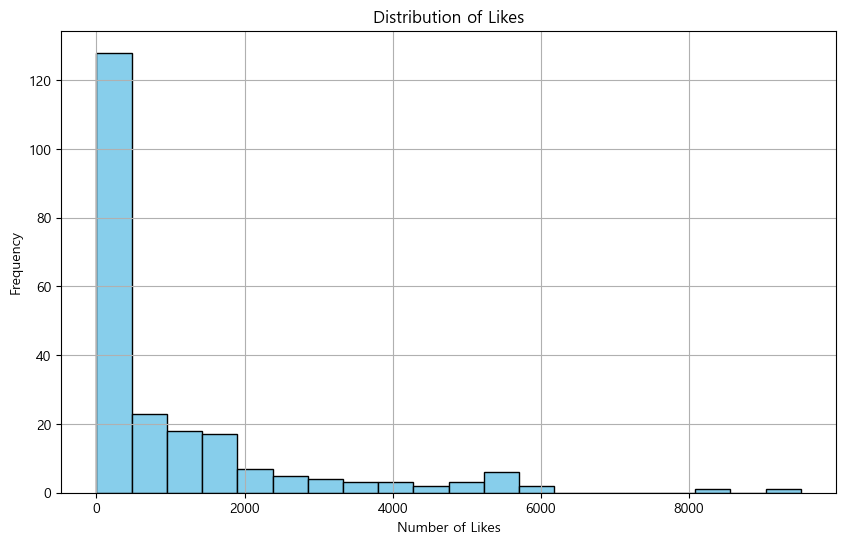

In [94]:
plt.figure(figsize=(10, 6))
plt.hist(results_df['like_count'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Likes')
plt.xlabel('Number of Likes')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [93]:
top_5_content = results_df.nlargest(5, 'like_count')['content']
pd.set_option('display.max_colwidth', None)
print(top_5_content)

150                                                                                                                꽃구경이 좋다며🌸.이제 날씨 좀 좋았으면🫠..#비그만#매화원 #기장매화원
69                                    여유롭게 벚꽃산책을 즐길 수 있는 곳🌸#염씨표류기 x #부산 아직 많이 알려지지 않은 곳이라서여유롭고 한적하게 산책을 즐길 수 있는 곳이에요떨어지는 벚꽃비를 맞으며 봄을 즐겨보세요!!🙌🙌📍동삼해수천📸23년 촬영
3      벚꽃 시즌에 당장 가야하는 부산🌸부산에서 꼭 가야하는 개금벚꽃길!이번에도 정말 기대가 되는 장소인데요✨오래된 골목길에 벚꽃나무가 한가득...여기 일본 갬성도 나서 미쳤어요😂알록달록한 집들도 짱많음🩵벚꽃 피면 호다닥 달려가세요!📷개금벚꽃길📍부산 부산진구 개금동 635
37     벚꽃 시즌에 당장 가야하는 부산🌸부산에서 꼭 가야하는 개금벚꽃길!이번에도 정말 기대가 되는 장소인데요✨오래된 골목길에 벚꽃나무가 한가득...여기 일본 갬성도 나서 미쳤어요😂알록달록한 집들도 짱많음🩵벚꽃 피면 호다닥 달려가세요!📷개금벚꽃길📍부산 부산진구 개금동 635
58                                      깔끔하게 정리해본 부산 겨울여행 동네별 총정리🎄🤍]맛집부터 카페, 여행지까지,,!부산은 겨울도 예쁘고 핫하다구❄@@우리 어디부터 가볼까-#부산여행추천 #부산여행지 #부산여행맛집 #부산여행중 #부산여행코스추천
Name: content, dtype: object
